<a href="https://colab.research.google.com/github/Jun-H-Lee/Fall-2020/blob/main/Macro_pset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 6

Parameters

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

alpha,beta, chi, delta, psi, sigma = 0.4, 0.9494, 0.1998, 0.08, 2, 4

In [2]:
!pip install quantecon
import quantecon as qe
sigma_z, rho = 0.008, 0.96
z_grid_size = 5
z_proc = qe.markov.approximation.rouwenhorst(z_grid_size, 0, sigma_z, rho)
z_grid = z_proc.state_values
z_tran = z_proc.P

     |████████████████████████████████| 235kB 2.7MB/s 


Utility Function and Optimal Choice of Labor

In [7]:
def u(c, n):
    """
    Utility function
    """
    return (c**(1 - sigma) - 1) / (1 - sigma) - chi * n ** (1 + psi) / (1 + psi)

def f(k,n,z_index):
    """
    Production Function
    """
    return np.exp(z_grid[z_index])*(k**alpha)*(n**(1-alpha))

def n_star(k, k_new, z_index):
    """
    Optimal Choice of Labor
    u_star : Optimized Utility
    n_opt : Optimizing Labor
    """
    n = np.linspace(1e-3, 3, 300)
    n_greedy = np.empty_like(n)
    for i in range(len(n)):
      if np.exp(z_grid[z_index])*k**alpha*n[i]**(1-alpha)-k_new+(1-delta)*k >= 0:
        n_greedy[i] = u(f(k,n[i],z_index)-k_new+(1-delta)*k, n[i])
      else:
        n_greedy[i] = -100000
    u_star = np.max(n_greedy)
    n_opt = np.argmax(n_greedy)

    return  u_star, n[n_opt]

Discretization

In [8]:
grid_max = 10
grid_size = 150
k_grid = np.linspace(1e-3, grid_max, grid_size)

Precomputing Optimal Labor

In [9]:
u_opt = np.zeros([grid_size, grid_size, z_grid_size])
n_opt = np.zeros([grid_size, grid_size, z_grid_size])

for i1 in range(grid_size):
  for i2 in range(grid_size):
    for i3 in range(z_grid_size):
      u_opt[i1, i2, i3], n_opt[i1, i2, i3] = n_star(k_grid[i1], k_grid[i2], i3)

Growth Model

In [10]:
class OptimalGrowthModel:

    def __init__(self,
                 u,            # utility function
                 f,            # production function
                 β=beta,       # discount factor
                 grid_max=grid_max,
                 grid_size=grid_size,
                 ):

        self.u, self.f, self.β = u, f, β

        # Set up grid
        self.grid = np.linspace(1e-3, grid_max, grid_size)

    def state_action_value(self, k_index, k_new_index, z_index, v_array):
        """
        Right hand side of the Bellman equation.
        """

        u, f, β = self.u, self.f, self.β
        u_val = u_opt[k_index, k_new_index, z_index]
        
        return u_val + β * np.sum(v_array[k_new_index, :] * z_tran[z_index,:])

Bellman Operator

In [11]:
def T(v, og):
    """
    The Bellman operator.  Updates the guess of the value function
    and also computes a v-greedy policy.

      * og is an instance of OptimalGrowthModel
      * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)

    for i1 in range(len(og.grid)):
      for i3 in range(len(z_grid)):
        v_greedy = np.zeros(len(og.grid))
        for i2 in range(len(og.grid)):
          v_greedy[i2] = og.state_action_value(i1, i2, i3, v)
        v_new[i1, i3] = np.max(v_greedy)

    return v_new

Value Function Iteration

In [12]:
def solve_model(og,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):
    """
    Solve model by iterating with the Bellman operator.

    """

    # Set up loop
    v = np.zeros((grid_size, len(z_grid)))  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v, og)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return  v_new

Finding Policy Function

In [13]:
def policy(v, og):
  """ 
  Get policy functions using the obtained value function
  """

  k_function = np.empty_like(v)
  n_function = np.empty_like(v)

  for i1 in range(len(og.grid)):
    for i3 in range(len(z_grid)):
      v_greedy = np.zeros(len(og.grid))
      for i2 in range(len(og.grid)):
        v_greedy[i2] = og.state_action_value(i1, i2, i3, v)
      
      k_function[i1, i3] = np.min(np.argmax(v_greedy))
      n_function[i1, i3] = n_opt[i1, k_function[i1, i3].astype(int), i3]  

  return k_function, n_function

Implementation

In [14]:
og = OptimalGrowthModel(u = u, f = f)
v = solve_model(og)
k_function, n_function = policy(v, og)

Error at iteration 25 is 39.12033290033651.
Error at iteration 50 is 0.011483735899871839.
Error at iteration 75 is 0.003025062786929489.
Error at iteration 100 is 0.0008170842302730463.
Error at iteration 125 is 0.00022218138252316777.

Converged in 141 iterations.


# Problem *7*

Generating TFP

In [25]:
np.random.seed(1234)
mc = qe.MarkovChain(z_tran)
X = mc.simulate(ts_length=1000)

Steady State

In [16]:
c = ((1 - beta * (1 - alpha)) / (alpha * beta))**(1/(1-alpha))
k_star = ((1 - alpha * (c **(1-alpha) - delta)**(-sigma)) / (chi * c ** psi))**(1/(psi + sigma - alpha))
n_star = c * k_star
i_star = delta * k_star
y_star = k_star ** alpha * n_star ** (1 - alpha)
c_star = y_star - i_star
print(k_star)
print(n_star)
print(i_star)
print(y_star)
print(c_star)

1.153643897933784
1.421050701958927
0.09229151183470272
1.3073577731061279
1.2150662612714251


Simulation

In [26]:
k_0_index = 11  #near k_star
results = np.zeros((6, len(X)+1))
results[1, 0] = k_0_index 
"""
1st row : value / 2nd row : capital_index / 3rd row : consumption / 4rd row : investment 
5th row : output / 6 th row: hours worked
"""
for i in range(len(X)):
  results[0, i] = v[results[1, i].astype(int), X[i]]
  results[1, i+1] = k_function[results[1, i].astype(int), X[i]]
  results[5, i] = n_function[results[1, i].astype(int), X[i]]
  results[4, i] = f(k_grid[results[1, i].astype(int)], results[5, i], X[i])
  results[2, i] = results[4, i] - k_grid[results[1, i+1].astype(int)] + (1-delta) * k_grid[results[1, i].astype(int)]
  results[3, i] = results[4, i] - results[2, i]

results = np.delete(results, len(X), 1)

Plotting

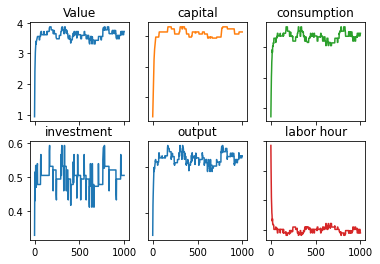

In [27]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].plot(results[0,:])
axs[0, 0].set_title('Value')
axs[0, 1].plot(results[1,:]*(grid_max / grid_size), 'tab:orange')
axs[0, 1].set_title('capital')
axs[0, 2].plot(results[2,:], 'tab:green')
axs[0, 2].set_title('consumption')
axs[1, 0].plot(results[3,:])
axs[1, 0].set_title('investment')
axs[1, 1].plot(results[4,:], 'tab:blue')
axs[1, 1].set_title('output')
axs[1, 2].plot(results[5,:], 'tab:red')
axs[1, 2].set_title('labor hour')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Problem *b*

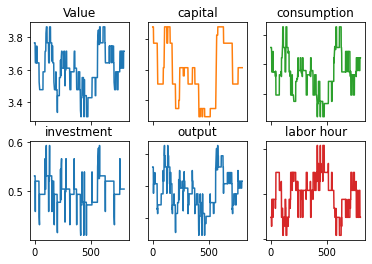

In [19]:
results = np.delete(results, np.arange(200), 1)
fig, axs = plt.subplots(2, 3)
axs[0, 0].plot(results[0,:])
axs[0, 0].set_title('Value')
axs[0, 1].plot(results[1,:]*(grid_max / grid_size), 'tab:orange')
axs[0, 1].set_title('capital')
axs[0, 2].plot(results[2,:], 'tab:green')
axs[0, 2].set_title('consumption')
axs[1, 0].plot(results[3,:])
axs[1, 0].set_title('investment')
axs[1, 1].plot(results[4,:], 'tab:blue')
axs[1, 1].set_title('output')
axs[1, 2].plot(results[5,:], 'tab:red')
axs[1, 2].set_title('labor hour')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [20]:
print("Captital : Steady state = ", k_star, "Model =", np.mean(results[1,:])*(grid_max / grid_size))
print("Consumption : Steady state = ", c_star, "Model =", np.mean(results[2,:]))
print("Investment : Steady state = ", i_star, "Model =", np.mean(results[3,:]))
print("Output : Steady state = ", y_star, "Model =", np.mean(results[4,:]))
print("Hours worked : Steady state = ", n_star, "Model =", np.mean(results[5,:]))

Captital : Steady state =  1.153643897933784 Model = 6.229666666666666
Consumption : Steady state =  1.2150662612714251 Model = 1.5835372419709275
Investment : Steady state =  0.09229151183470272 Model = 0.5013285278523485
Output : Steady state =  1.3073577731061279 Model = 2.084865769823276
Hours worked : Steady state =  1.421050701958927 Model = 0.9997973913043476


Problem *c*

In [21]:
print("Output:")
print("    Standard Deviation:")
print("  Data : 1.70 / Model : ", np.std(results[4,:]))
print("Consumption:")
print("    Standard Deviation:")
print("  Data : 0.80 / Model : ", np.std(results[2,:]))
print("Investment:")
print("    Standard Deviation:")
print("  Data : 6.49 / Model : ", np.std(results[3,:]))
print("Hours worked:")
print("    Standard Deviation:")
print("  Data : 1.69 / Model : ", np.std(results[5,:]))

Output:
    Standard Deviation:
  Data : 1.70 / Model :  0.05592240920407306
Consumption:
    Standard Deviation:
  Data : 0.80 / Model :  0.03488071626222736
Investment:
    Standard Deviation:
  Data : 6.49 / Model :  0.026461469527881448
Hours worked:
    Standard Deviation:
  Data : 1.69 / Model :  0.02175306553719596


In [22]:
print("Output:")
print("    Standard Deviation :")
print("  Data : 1 / Model : ", 1)
print("Consumption:")
print("    Ratio of Standard Deviation to Output Standard Deviation:")
print("  Data : 0.47 / Model : ", np.std(results[2,:])/np.std(results[4,:]))
print("Investment:")
print("    Ratio of Standard Deviation to Output Standard Deviation:")
print("  Data : 3.83 / Model : ", np.std(results[3,:])/np.std(results[4,:]))
print("Hours worked:")
print("    Ratio of Standard Deviation to Output Standard Deviation:")
print("  Data : 1.00 / Model : ", np.std(results[5,:])/np.std(results[4,:]))

Output:
    Standard Deviation :
  Data : 1 / Model :  1
Consumption:
    Ratio of Standard Deviation to Output Standard Deviation:
  Data : 0.47 / Model :  0.6237341480575348
Investment:
    Ratio of Standard Deviation to Output Standard Deviation:
  Data : 3.83 / Model :  0.47318185865916074
Hours worked:
    Ratio of Standard Deviation to Output Standard Deviation:
  Data : 1.00 / Model :  0.3889865591772751
